In [1]:
!pip install bing_image_downloader
!pip install pyblp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.2 MB/s eta 0:00:00


### Load BLP Data and Images

In [2]:
import os
import shutil
from tqdm import tqdm
from bing_image_downloader import downloader
from PIL import Image
import torch
from torchvision import models, transforms
import pyblp
import pandas as pd

# Load data
df = pd.read_csv(pyblp.data.BLP_PRODUCTS_LOCATION)
#df['manufacturer'] = df['clustering_ids'].astype(str).str[:2].map(car_manufacturers)
df['model'] = df['clustering_ids'].astype(str).str[2:-2]
df['year'] = '19' + df['clustering_ids'].astype(str).str[-2:]
df['query'] = df['clustering_ids'].astype(str).map(codes)

NameError: name 'codes' is not defined

In [ ]:
df.head()

,market_ids,clustering_ids,car_ids,firm_ids,region,shares,prices,hpwt,air,mpd,...,supply_instruments5,supply_instruments6,supply_instruments7,supply_instruments8,supply_instruments9,supply_instruments10,supply_instruments11,model,year,query
0,1971,AMGREM71,129,15,US,0.001051,4.935802,0.528997,0,1.888146,...,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.888146,GREM,1971,American Motors Gremlin (1971)
1,1971,AMHORN71,130,15,US,0.000670,5.516049,0.494324,0,1.935989,...,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.935989,HORN,1971,American Motors Hornet (1971)
2,1971,AMJAVL71,132,15,US,0.000341,7.108642,0.467613,0,1.716799,...,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.716799,JAVL,1971,American Motors Javelin (1971)
3,1971,AMMATA71,134,15,US,0.000522,6.839506,0.426540,0,1.687871,...,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.687871,MATA,1971,American Motors Matador (1971)
4,1971,AMAMBS71,136,15,US,0.000442,8.928395,0.452489,0,1.504286,...,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.504286,AMBS,1971,American Motors Ambassador (1971)


### Load image tensors

In [ ]:
import torch
import numpy as np
pixel_tensors_path = '/content/drive/MyDrive/blp-cnn/pixel_tensors.pt'  # Update with your file path
queries_path = '/content/drive/MyDrive/blp-cnn/queries.npy'            # Update with your file path
pixel_tensors = torch.load(pixel_tensors_path)
queries = np.load(queries_path)
processed_queries = [query.split('"')[1] for query in queries if '"' in query]
print(len(processed_queries), pixel_tensors.shape)

In [ ]:
df['query'] = df['query'].str.replace(")","").str.replace("(","")
print(df[df['query'].isin(processed_queries)].shape[0])
import torch
query_to_tensor = {query: tensor for query, tensor in zip(processed_queries, pixel_tensors)}
average_tensor = torch.mean(pixel_tensors, dim=0)
image_tensors_list = []
for query in df['query']:
    if query in query_to_tensor:
        image_tensors_list.append(query_to_tensor[query])
    else:
        image_tensors_list.append(average_tensor)
images_tensor = torch.stack(image_tensors_list)
images_tensor = images_tensor.float() / 255

### Prepare the data

In [ ]:
df = pd.read_csv(pyblp.data.BLP_PRODUCTS_LOCATION)
df['model'] = df['clustering_ids'].astype(str).str[2:-2]
df['year'] = '19' + df['clustering_ids'].astype(str).str[-2:]
df['query'] = df['clustering_ids'].astype(str).map(codes)
df['shares'] = np.log(df.shares)
outcomes = 'shares'
treatment = 'prices'
covariates = ['hpwt', 'air', 'mpd', 'mpg', 'space', 'trend']
image = ['image']
instruments = ['demand_instruments0', 'demand_instruments1', 'demand_instruments2', 'demand_instruments3', 'demand_instruments4', 'demand_instruments5', 'demand_instruments6', 'demand_instruments7']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y = torch.tensor(df[outcomes].values, dtype=torch.float32).reshape(-1).to(device)
t = torch.tensor(df[treatment].values, dtype=torch.float32).reshape(-1).to(device)
x1 = torch.tensor(df[covariates].values, dtype=torch.float32).to(device)
x = images_tensor.clone().to(device)
z = torch.tensor(df[instruments].values, dtype=torch.float32).to(device)
y.shape, t.shape, x.shape, z.shape, x1.shape

### Initialize

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train, x_test, y_train, y_test, t_train, t_test, z_train, z_test, x1_train, x1_test = train_test_split(x, y, t, z, x1, test_size=0.2)
d_x = x_train.shape[1]
d_z = z.shape[1]
n = x_train.shape[0]

### Dataloader

In [ ]:
# Convert to PyTorch tensors if they aren't already
x1_train = torch.tensor(x1_train, dtype=torch.float32)
z_train = torch.tensor(z_train, dtype=torch.float32)
x1_test = torch.tensor(x1_test, dtype=torch.float32)
z_test = torch.tensor(z_test, dtype=torch.float32)

# Normalize x1
x1_mean = x1_train.mean(dim=0, keepdim=True)
x1_std = x1_train.std(dim=0, keepdim=True)
x1_train = (x1_train - x1_mean) / x1_std
x1_test = (x1_test - x1_mean) / x1_std  # Use train mean and std for test normalization

# Normalize z
z_mean = z_train.mean(dim=0, keepdim=True)
z_std = z_train.std(dim=0, keepdim=True)
z_train = (z_train - z_mean) / z_std
z_test = (z_test - z_mean) / z_std  # Use train mean and std for test normalization

<ipython-input-17-800fb6a9ca58>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1_train = torch.tensor(x1_train, dtype=torch.float32)
<ipython-input-17-800fb6a9ca58>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_train = torch.tensor(z_train, dtype=torch.float32)
<ipython-input-17-800fb6a9ca58>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1_test = torch.tensor(x1_test, dtype=torch.float32)
<ipython-input-17-800fb6a9ca58>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or s

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
batch_size = 128
train_dataset = TensorDataset(x_train, x1_train, z_train, t_train, y_train)
test_dataset = TensorDataset(x_test, x1_test, z_test, t_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Treatment Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNXZ(nn.Module):
    def __init__(self, img_size=120, num_filters=64, d_output=1, d_x=10, d_z=10):
        super(CNNXZ, self).__init__()
        # Convolutional layers for image processing
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=5, stride=1, padding=2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(num_filters, num_filters // 2, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(num_filters // 2)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Calculate output size after convolution and pooling layers
        conv_output_size = img_size // 4  # Adjusted for two pooling layers
        self.img_feature_size = (num_filters // 2) * conv_output_size * conv_output_size

        # Fully connected layers for covariate processing
        self.fc_covariates_x = nn.Linear(d_x, 50)
        self.fc_covariates_z = nn.Linear(d_z, 50)

        # Combined fully connected layer
        self.fc_combined = nn.Linear(self.img_feature_size + 50 + 50, d_output)

    def forward(self, x_img, x_covariates, z_covariates):
        # Image processing
        x_img = self.pool1(self.bn1(F.relu(self.conv1(x_img))))
        x_img = self.dropout1(x_img)
        x_img = self.pool2(self.bn2(F.relu(self.conv2(x_img))))
        x_img = self.dropout2(x_img)
        x_img = torch.flatten(x_img, 1)

        # Covariate processing
        x_covariates = F.relu(self.fc_covariates_x(x_covariates))
        z_covariates = F.relu(self.fc_covariates_z(z_covariates))

        # Combine and process
        combined_input = torch.cat((x_img, x_covariates, z_covariates), dim=1)
        output = self.fc_combined(combined_input)
        return output

In [ ]:
m = 1000
model_cd = CNNXZ(d_x = x1.shape[1], d_z = z.shape[1]).to(device)
loss_fn = nn.MSELoss(reduction='mean')

In [ ]:
optimizer_cd = torch.optim.Adam(chain(model_cd.parameters()), lr=0.0001, weight_decay=0.0000)
for i in range(m):
    for x_batch, x1_batch, z_batch, t_batch, y_batch in train_loader:
        t_hat = model_cd(x_batch, x1_batch, z_batch).reshape(-1).to(device)
        loss_t = loss_fn(t_hat, t_batch)
        l2_lambda = 0.0001
        l2_reg = torch.tensor(0.).to(device)
        for param in model_cd.parameters():
            l2_reg += torch.norm(param)
        loss_t += l2_lambda * l2_reg
        optimizer_cd.zero_grad()
        loss_t.backward()
        optimizer_cd.step()
    if i % 10 == 0:
        print(f"Epoch [{i}/{m}], Loss for t: {loss_t.item()}")
        with torch.no_grad():
            all_t_hat_test = []
            for x_test_batch, x1_test_batch, z_test_batch, t_test_batch, y_test_batch in test_loader:
                t_hat_test = model_cd(x_test_batch, x1_test_batch, z_test_batch).reshape(-1).to(device)
                all_t_hat_test.append(t_hat_test.cpu())
            t_hat_test_all = torch.cat(all_t_hat_test)
            r2_t = r2_score(t_test.cpu(), t_hat_test_all)
            print(f"(Test) R2 Score for t: {r2_t}")
torch.save(model_cd.state_dict(), 'model_cd_trained.pth')

Epoch [0/1000], Loss for t: 29.890628814697266
(Test) R2 Score for t: 0.3562657166628861
Epoch [10/1000], Loss for t: 43.119415283203125
(Test) R2 Score for t: 0.4720796964716414
Epoch [20/1000], Loss for t: 7.837245941162109
(Test) R2 Score for t: 0.5406730472818289
Epoch [30/1000], Loss for t: 8.051907539367676
(Test) R2 Score for t: 0.5919868236907779
Epoch [40/1000], Loss for t: 6.2674031257629395
(Test) R2 Score for t: 0.6292159262219819
Epoch [50/1000], Loss for t: 7.003805160522461
(Test) R2 Score for t: 0.6240537098500285
Epoch [60/1000], Loss for t: 5.725185871124268
(Test) R2 Score for t: 0.655111686645246
Epoch [70/1000], Loss for t: 5.81990385055542
(Test) R2 Score for t: 0.6634693739969604
Epoch [80/1000], Loss for t: 15.35578727722168
(Test) R2 Score for t: 0.6664963354916565
Epoch [90/1000], Loss for t: 26.54822540283203
(Test) R2 Score for t: 0.676467557873786


### Outcome Model

In [ ]:
class CNNX(nn.Module):
    def __init__(self, img_size=120, num_filters=64, d_output=2, d_x=10):
        super(CNNX, self).__init__()
        # Convolutional layers for image processing
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=5, stride=1, padding=2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(num_filters, num_filters // 2, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(num_filters // 2)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Calculate output size after convolution and pooling layers
        conv_output_size = img_size // 4  # Adjusted for two pooling layers
        self.img_feature_size = (num_filters // 2) * conv_output_size * conv_output_size

        # Fully connected layer for covariate processing
        self.fc_covariates = nn.Linear(d_x, 50)

        # Combined fully connected layer
        self.fc_combined = nn.Linear(self.img_feature_size + 50, d_output)

    def forward(self, x_img, x_covariates):
        # Image processing
        x_img = self.pool1(self.bn1(F.relu(self.conv1(x_img))))
        x_img = self.dropout1(x_img)
        x_img = self.pool2(self.bn2(F.relu(self.conv2(x_img))))
        x_img = self.dropout2(x_img)
        x_img = torch.flatten(x_img, 1)

        # Covariate processing
        x_covariates = F.relu(self.fc_covariates(x_covariates))

        # Combine and process
        combined_input = torch.cat((x_img, x_covariates), dim=1)
        output = self.fc_combined(combined_input)
        return output

In [ ]:
class CNNX(nn.Module):
    def __init__(self, img_size=120, num_filters=3, d_output=2, d_x=10):
        super(CNNX, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=3, stride=1)
        conv_output_size = img_size - 2  # Adjusted for kernel_size=3, stride=1
        self.img_feature_size = num_filters * conv_output_size * conv_output_size
        self.fc_covariates = nn.Linear(d_x, 50) # Example dimension for hidden layer
        self.fc_combined = nn.Linear(self.img_feature_size + 50, d_output)

    def forward(self, x_img, x_covariates):
        x_img = F.relu(self.conv1(x_img))
        x_img = torch.flatten(x_img, 1)
        x_covariates = F.relu(self.fc_covariates(x_covariates))
        combined_input = torch.cat((x_img, x_covariates), dim=1)
        output = self.fc_combined(combined_input)
        return output

In [ ]:
model_ab = CNNX(d_x = x1.shape[1]).to(device)
optimizer_ab = torch.optim.Adam(chain(model_ab.parameters()), lr=0.0001, weight_decay=0.0000)

In [ ]:
for i in range(m):
    for x_batch, x1_batch, z_batch, t_batch, y_batch in train_loader:
        t_hat = model_cd(x_batch, x1_batch, z_batch).reshape(-1).to(device).detach()
        ab = model_ab(x_batch, x1_batch)
        alpha = ab[:,0].reshape(-1,)
        beta = ab[:,1].reshape(-1,)
        y_hat = (alpha + beta * t_hat).to(device)
        loss_y = loss_fn(y_hat, y_batch)
        l2_lambda = 0.0002
        l2_reg = torch.tensor(0.).to(device)
        for param in model_ab.parameters():
            l2_reg += torch.norm(param)
        loss_y += l2_lambda * l2_reg
        optimizer_ab.zero_grad()
        loss_y.backward()
        optimizer_ab.step()

    if i % (m / 100) == 0:
        print(f"Epoch [{i}/{m}], Loss for y: {loss_y.item()}")
        with torch.no_grad():
            all_y_hat_test = []
            for x_test_batch, x1_test_batch, z_test_batch, t_test_batch, y_test_batch in test_loader:
                t_hat_test = model_cd(x_test_batch, x1_test_batch, z_test_batch).reshape(-1).to(device).detach()
                ab_test = model_ab(x_test_batch, x1_test_batch)
                alpha_test = ab_test[:,0].reshape(-1,)
                beta_test = ab_test[:,1].reshape(-1,)
                y_hat_test = (alpha_test + beta_test * t_hat_test).to(device)
                all_y_hat_test.append(y_hat_test.cpu())

            y_hat_test_all = torch.cat(all_y_hat_test)
            r2_y = r2_score(y_test.cpu(), y_hat_test_all)
            print(f"(Test) R2 Score for y: {r2_y}")

Epoch [0/1000], Loss for y: 28.80821418762207
(Test) R2 Score for y: -11.79647698159516
Epoch [10/1000], Loss for y: 7.481409549713135
(Test) R2 Score for y: -2.0724774749473736
Epoch [20/1000], Loss for y: 1.4250465631484985
(Test) R2 Score for y: -0.04660157867877368
Epoch [30/1000], Loss for y: 1.5016961097717285
(Test) R2 Score for y: 0.13200265179398352
Epoch [40/1000], Loss for y: 0.9925631880760193
(Test) R2 Score for y: 0.17425840006395388
Epoch [50/1000], Loss for y: 1.5596790313720703
(Test) R2 Score for y: 0.18081469086272184
Epoch [60/1000], Loss for y: 0.9792786240577698
(Test) R2 Score for y: 0.2356159574990604
Epoch [70/1000], Loss for y: 1.1245629787445068
(Test) R2 Score for y: 0.2753939135269884
Epoch [80/1000], Loss for y: 1.2770715951919556
(Test) R2 Score for y: 0.24064478075033535
Epoch [90/1000], Loss for y: 1.1409997940063477
(Test) R2 Score for y: 0.2852580160491456
Epoch [100/1000], Loss for y: 1.0072987079620361
(Test) R2 Score for y: 0.29669324454753665
Epoc

KeyboardInterrupt: 

### 2SLS-IV

In [11]:
#df = pd.read_csv(pyblp.data.BLP_PRODUCTS_LOCATION)
#carids = list(df.clustering_ids.unique())
#df['shares'] = np.log(df.shares)
outcomes = 'shares'
treatment = 'prices'
covariates = ['hpwt', 'air',  'mpd', 'mpg', 'space', 'trend']
image = ['image']
instruments = ['demand_instruments0',  'demand_instruments1', 'demand_instruments2','demand_instruments3', 'demand_instruments4', 'demand_instruments5','demand_instruments6', 'demand_instruments7']
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
endog = df[outcomes]
exog =  df[[treatment] + covariates]
instr = df[covariates + instruments]
exog_constant = sm.add_constant(exog)
instr_constant = sm.add_constant(instr)
IV2SLS = IV2SLS(endog, exog_constant, instrument = instr_constant).fit()
print(IV2SLS.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                 shares   R-squared:                       0.144
Model:                         IV2SLS   Adj. R-squared:                  0.142
Method:                     Two Stage   F-statistic:                     67.03
                        Least Squares   Prob (F-statistic):           6.48e-88
Date:                Mon, 29 Jan 2024                                         
Time:                        03:11:36                                         
No. Observations:                2217                                         
Df Residuals:                    2209                                         
Df Model:                           7                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.543      0.1

### Heterogenous Price Sensitivity

In [ ]:
# Move the model to CPU
model_ab.to('cpu')

# Define batch size for processing
batch_size = 256  # Adjust this based on your available CPU memory

# Calculate the number of batches
num_batches = int(np.ceil(x_train.size(0) / batch_size))

all_alpha = []
all_beta = []

# Process in smaller batches
for i in range(num_batches):
    print(f"Processing batch {i+1}/{num_batches}")

    # Extract a batch
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, x_train.size(0))

    # Ensure the batch is on CPU
    x_batch = x_train[start_idx:end_idx].to('cpu')
    x1_batch = x1_train[start_idx:end_idx].to('cpu')

    # Forward pass
    try:
        ab = model_ab(x_batch, x1_batch)
        alpha = ab[:,0].reshape(-1,)
        beta = ab[:,1].reshape(-1,)
    except RuntimeError as e:
        print("RuntimeError:", e)
        continue

    # Store results
    all_alpha.append(alpha)
    all_beta.append(beta)

    # Clear some memory
    del x_batch, x1_batch, ab, alpha, beta

# Concatenate all results
all_alpha = torch.cat(all_alpha)
all_beta = torch.cat(all_beta)

Processing batch 1/7
Processing batch 2/7
Processing batch 3/7
Processing batch 4/7
Processing batch 5/7
Processing batch 6/7
Processing batch 7/7


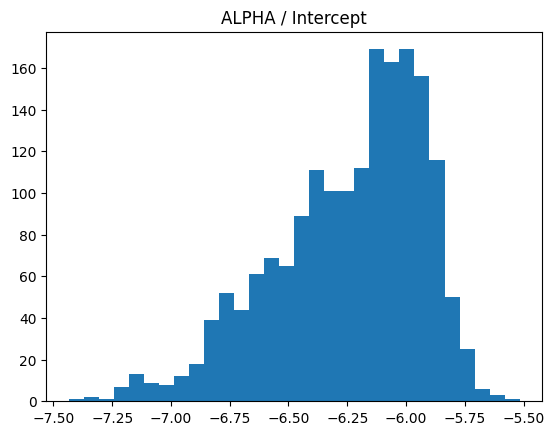

In [ ]:
import matplotlib.pyplot as plt
plt.hist(all_alpha.detach().numpy(), bins = 30)
plt.title('ALPHA / Intercept')
plt.show()

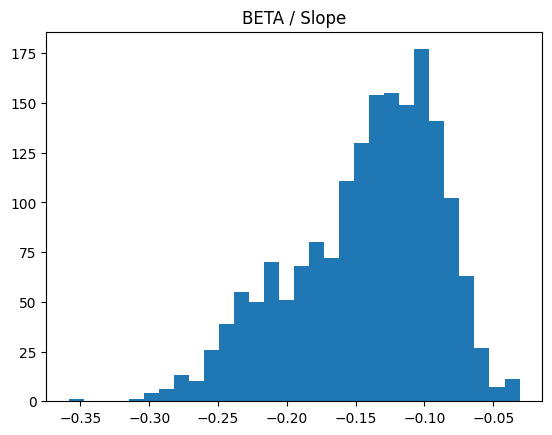

In [ ]:
import matplotlib.pyplot as plt
plt.hist(all_beta.detach().numpy(), bins = 30)
plt.title('BETA / Slope')
plt.show()

In [ ]:
# Move the model to CPU
model_ab.to('cpu')

# Define batch size for processing
batch_size = 256  # Adjust this based on your available CPU memory

# Calculate the number of batches
num_batches = int(np.ceil(x_train.size(0) / batch_size))

# Compute the mean of x1
x1_mean = x1_train.mean(dim=0)

all_alpha = []
all_beta = []

# Process in smaller batches
for i in range(num_batches):
    print(f"Processing batch {i+1}/{num_batches}")

    # Extract a batch
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, x_train.size(0))

    # Ensure the batch is on CPU and use the mean value for x1
    x_batch = x_train[start_idx:end_idx].to('cpu')
    x1_batch_mean = x1_mean.unsqueeze(0).expand(x_batch.size(0), -1).to('cpu')  # Expand the mean to match the batch size

    # Forward pass
    try:
        ab = model_ab(x_batch, x1_batch_mean)
        alpha = ab[:,0].reshape(-1,)
        beta = ab[:,1].reshape(-1,)
    except RuntimeError as e:
        print("RuntimeError:", e)
        continue

    # Store results
    all_alpha.append(alpha)
    all_beta.append(beta)

    # Clear some memory
    del x_batch, x1_batch_mean, ab, alpha, beta

# Concatenate all results
all_alpha = torch.cat(all_alpha)
all_beta = torch.cat(all_beta)

NameError: name 'model_ab' is not defined

(array([ 10.,   3.,   0.,   3.,   1.,   5.,   3.,  18.,  48.,  63., 101.,
        124., 175., 188., 374., 183., 159.,  88.,  84.,  54.,  41.,  17.,
         10.,   4.,   7.,   2.,   4.,   0.,   0.,   4.]),
 array([-6.34171867, -6.31920671, -6.29669476, -6.27418232, -6.25167036,
        -6.2291584 , -6.20664644, -6.18413448, -6.16162252, -6.13911057,
        -6.11659813, -6.09408617, -6.07157421, -6.04906225, -6.02655029,
        -6.00403786, -5.9815259 , -5.95901394, -5.93650198, -5.91399002,
        -5.89147806, -5.8689661 , -5.84645367, -5.82394171, -5.80142975,
        -5.77891779, -5.75640583, -5.73389339, -5.71138144, -5.68886948,
        -5.66635752]),
 <BarContainer object of 30 artists>)

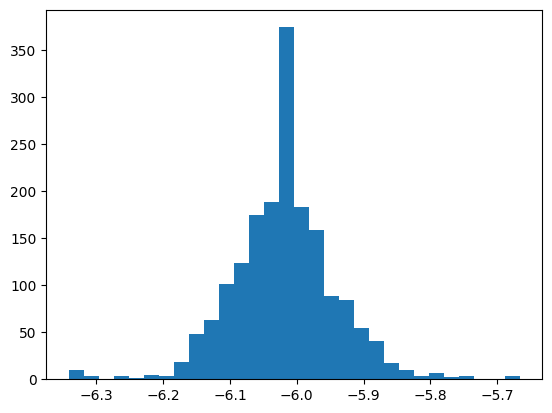

In [ ]:
import matplotlib.pyplot as plt
plt.hist(all_alpha.detach().numpy(), bins = 30)

(array([  5.,   7.,  16.,  24.,  29.,  45.,  38.,  51.,  63.,  78.,  73.,
        102.,  93., 101., 279., 116.,  96., 123.,  79.,  69.,  67.,  59.,
         50.,  41.,  19.,  27.,  12.,   4.,   2.,   5.]),
 array([-0.13560268, -0.13480078, -0.13399887, -0.13319698, -0.13239507,
        -0.13159317, -0.13079126, -0.12998936, -0.12918745, -0.12838556,
        -0.12758365, -0.12678175, -0.12597984, -0.12517793, -0.12437604,
        -0.12357414, -0.12277223, -0.12197033, -0.12116843, -0.12036652,
        -0.11956462, -0.11876272, -0.11796081, -0.1171589 , -0.11635701,
        -0.1155551 , -0.1147532 , -0.1139513 , -0.11314939, -0.11234749,
        -0.11154559]),
 <BarContainer object of 30 artists>)

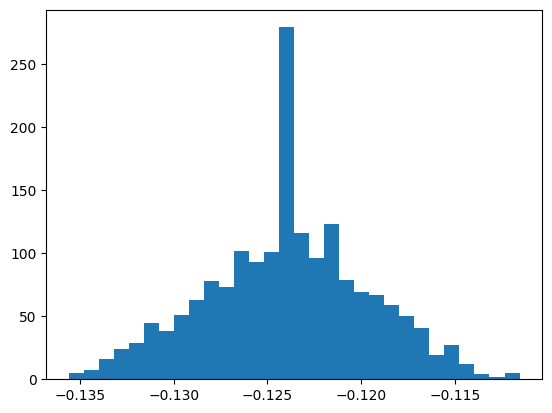

In [ ]:
import matplotlib.pyplot as plt
plt.hist(all_beta.detach().numpy(), bins = 30)

In [ ]:
## Convert lists to numpy arrays for easier manipulation
alphas_np = all_alpha.detach().numpy()
betas_np = all_beta.detach().numpy()

# Determine the top/bottom 5% indices
top_5_alpha_idx = np.argsort(alphas_np)[-int(0.05 * len(alphas_np)):]
bottom_5_alpha_idx = np.argsort(alphas_np)[:int(0.05 * len(alphas_np))]

top_5_beta_idx = np.argsort(betas_np)[-int(0.05 * len(betas_np)):]
bottom_5_beta_idx = np.argsort(betas_np)[:int(0.05 * len(betas_np))]

# Retrieve the corresponding queries
top_5_alpha_queries = [df['query'].iloc[idx] for idx in top_5_alpha_idx]
bottom_5_alpha_queries = [df['query'].iloc[idx]  for idx in bottom_5_alpha_idx]

top_5_beta_queries = [df['query'].iloc[idx] for idx in top_5_beta_idx]
bottom_5_beta_queries = [df['query'].iloc[idx] for idx in bottom_5_beta_idx]

# Output the results
print("Top 5% Alpha Queries:", top_5_alpha_queries)
print("Bottom 5% Alpha Queries:", bottom_5_alpha_queries)
print("Top 5% Beta Queries:", top_5_beta_queries)
print("Bottom 5% Beta Queries:", bottom_5_beta_queries)

Top 5% Alpha Queries: ['Plymouth Horizon (1980)', 'Chrysler Newport 1971', 'Oldsmobile Toronado (1972)', 'Fiat 128 1976', 'Ford Torino 1972', nan, 'Mazda GLC (1979)', 'Toyota Corona (1971)', 'American Motors Eagle (1984)', 'Honda Prelude 1979', 'Chevrolet Nova 1985', 'Peugeot 505 Grand (1986)', 'Oldsmobile 98 (1975)', 'Saab 99 RE (1972)', 'Chevrolet Biscayne 1972', 'Ford Granada 1977', 'Toyota Supra (1986)', 'Datsun 200SX Hardtop automatic 1981', 'Alfa Romeo Milano (1987)', 'Pontiac T1000 (1981)', nan, 'Chevrolet Celebrity 1982', 'Dodge 600 1983', nan, 'Volvo Turbo (1983)', 'American Motors Pacer (1975)', 'Oldsmobile 98 (1981)', 'Mercedes-Benz 300D (1985)', 'Pontiac Bonneville (1971)', nan, 'Mercedes-Benz 380S (1982)', 'Toyota Corona (1974)', 'Buick LeSabre 1976', 'Renault Fuego (1983)', 'Pontiac J2000 (1982)', 'Pontiac Bonneville (1980)', 'Chevrolet Monte Carlo 1985', 'Plymouth Champ (1979)', 'Pontiac Grand Prix (1973)', 'Volkswagen Beetle (1974)', 'BMW 633CSi 1981', 'Alfa Romeo Spide

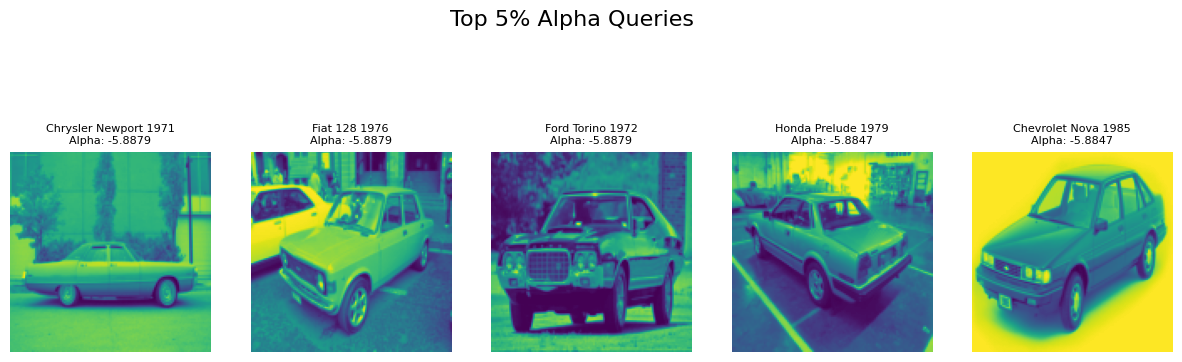

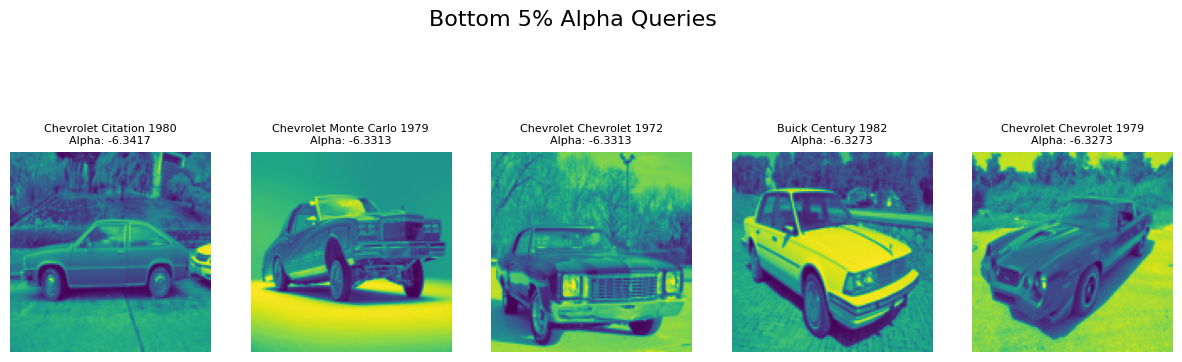

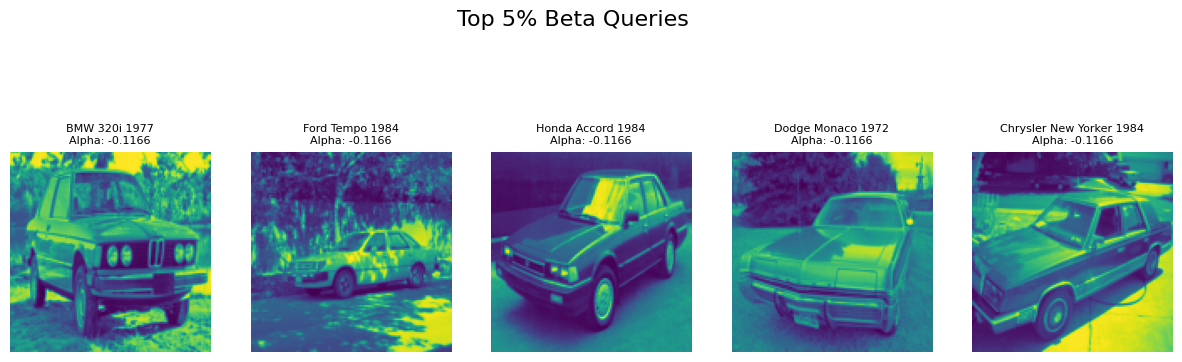

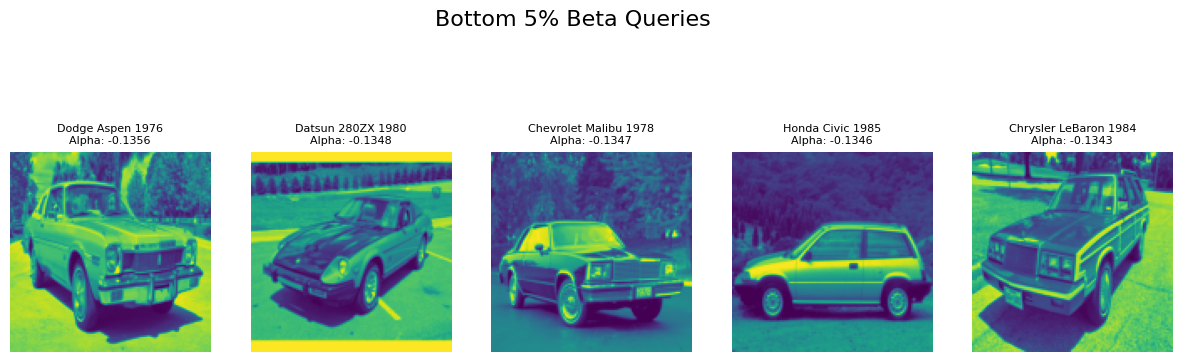

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

def display_images(queries, query_to_tensor, alpha_values, title, num_images=5):
    # Filter valid queries and limit to the first 'num_images'
    valid_queries = [(query, alpha) for query, alpha in zip(queries, alpha_values) if query in query_to_tensor][:num_images]

    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i, (query, alpha_value) in enumerate(valid_queries):
        # Retrieve the image tensor
        image_tensor = query_to_tensor[query]

        # Convert image tensor to PIL image
        image = transforms.ToPILImage()(image_tensor.squeeze(0))
        plt.subplot(1, len(valid_queries), i + 1)
        plt.imshow(image)
        plt.title(f"{query}\nAlpha: {alpha_value:.4f}", fontsize=8)
        plt.axis('off')

    plt.show()

# Example usage
top_5_alpha_values = alphas_np[top_5_alpha_idx]
bottom_5_alpha_values = alphas_np[bottom_5_alpha_idx]
top_5_beta_values = betas_np[top_5_beta_idx]
bottom_5_beta_values = betas_np[bottom_5_beta_idx]

display_images(top_5_alpha_queries, query_to_tensor, top_5_alpha_values, "Top 5% Alpha Queries")
display_images(bottom_5_alpha_queries, query_to_tensor, bottom_5_alpha_values, "Bottom 5% Alpha Queries")
display_images(top_5_beta_queries, query_to_tensor, top_5_beta_values, "Top 5% Beta Queries")
display_images(bottom_5_beta_queries, query_to_tensor, bottom_5_beta_values, "Bottom 5% Beta Queries")

### Models List

In [ ]:
codes = {
    'ACINTE86': 'Acura Integra (1986)',
    'ACLEGE86': 'Acura Legend (1986)',
    'ACINTE90': 'Acura Integra (1990)',
    'ADSUPE71': 'Audi Super (1971)',
    'AD100L71': 'Audi 100 (1971)',
    'AD9072': 'Audi 90 (1972)',
    'AD100L75': 'Audi 100 (1975)',
    'ADFOX75': 'Audi Fox (1975)',
    'AD500078': 'Audi 5000 (1978)',
    'AD500080': 'Audi 5000 (1980)',
    'AD400080': 'Audi 4000 (1980)',
    'AD500081': 'Audi 5000 (1981)',
    'ADCOUP81': 'Audi Coupe (1981)',
    'AD500083': 'Audi 5000 (1983)',
    'AD400084': 'Audi 4000 (1984)',
    'AD400085': 'Audi 4000 (1985)',
    'AD500088': 'Audi 5000 (1988)',
    'AD8088': 'Audi 80 (1988)',
    'AD9088': 'Audi 90 (1988)',
    'AD100289': 'Audi 100 (1989)',
    'AD80SE90': 'Audi 80 (1990)',
    'AD90SE90': 'Audi 90 (1990)',
    'AD100S90': 'Audi 100 (1990)',
    'AD200S90': 'Audi 200 (1990)',
    'AMGREM71': 'American Motors Gremlin (1971)',
    'AMHORN71': 'American Motors Hornet (1971)',
    'AMJAVL71': 'American Motors Javelin (1971)',
    'AMMATA71': 'American Motors Matador (1971)',
    'AMAMBS71': 'American Motors Ambassador (1971)',
    'AMGREM72': 'American Motors Gremlin (1972)',
    'AMHORN72': 'American Motors Hornet (1972)',
    'AMJAVL72': 'American Motors Javelin (1972)',
    'AMMATA72': 'American Motors Matador (1972)',
    'AMGREM75': 'American Motors Gremlin (1975)',
    'AMPACE75': 'American Motors Pacer (1975)',
    'AMHORN76': 'American Motors Hornet (1976)',
    'AMGREM77': 'American Motors Gremlin (1977)',
    'AMCONC78': 'American Motors Concord (1978)',
    'AMMATA78': 'American Motors Matador (1978)',
    'AMSPIR79': 'American Motors Spirit (1979)',
    'AMPACE79': 'American Motors Pacer (1979)',
    'AMEAGL80': 'American Motors Eagle (1980)',
    'AMEGL-81': 'American Motors Eagle (1981)',
    'AMSPIR82': 'American Motors Spirit (1982)',
    'AMEGL-82': 'American Motors Eagle (1982)',
    'AMALIN83': 'American Motors Alliance (1983)',
    'AMEGL-83': 'American Motors Eagle (1983)',
    'AMENCO84': 'American Motors Encore (1984)',
    'AMALLI84': 'American Motors Alliance (1984)',
    'AMEAGL84': 'American Motors Eagle (1984)',
    'AMEAGL85': 'American Motors Eagle (1985)',
    'AR200072': 'Alfa Romeo 2000 Sportiva (1972)',
    'ARALFE75': 'Alfa Romeo Alfetta (1975)',
    'ARALFT76': 'Alfa Romeo Alfetta (1976)',
    'ARSPOR77': 'Alfa Romeo Sport (1977)',
    'ARSPID80': 'Alfa Romeo Spider (1980)',
    'ARSPID81': 'Alfa Romeo Spider (1981)',
    'ARGTV681': 'Alfa Romeo GTV (1981)',
    'ARSPID82': 'Alfa Romeo Spider (1982)',
    'ARMILA87': 'Alfa Romeo Milano (1987)',
    'ARSPDR90': 'Alfa Romeo Spider (1990)',
    'BKSKYL71': 'Buick Skylark 1971',
    'BKLSAB71': 'Buick LeSabre 1971',
    'BKCNTU71': 'Buick Centurion 1971',
    'BKELCT71': 'Buick Electra 1971',
    'BKRIVE71': 'Buick Riviera 1971',
    'BKLSAB72': 'Buick LeSabre 1972',
    'BKCNTU72': 'Buick Centurion 1972',
    'BKELCT72': 'Buick Electra 1972',
    'BKRIVE72': 'Buick Riviera 1972',
    'BKAPOL73': 'Buick Apollo 1973',
    'BKCENT73': 'Buick Century 1973',
    'BKCNTU73': 'Buick Centurion 1973',
    'BKRIVE74': 'Buick Riviera 1974',
    'BKSKYH75': 'Buick Skyhawk 1975',
    'BKSKYL75': 'Buick Skylark 1975',
    'BKCENT75': 'Buick Century 1975',
    'BKLSAB76': 'Buick LeSabre 1976',
    'BKELCT77': 'Buick Electra 1977',
    'BKRIVE77': 'Buick Riviera 1977',
    'BKCNTS78': 'Buick Century Special 1978',
    'BKSKYL79': 'Buick Skylark 1979',
    'BKREGA79': 'Buick Regal 1979',
    'BKSKYL80': 'Buick Skylark 1980',
    'BKELCT80': 'Buick Electra 1980',
    'BKRIVE81': 'Buick Riviera 1981',
    'BKSKYH82': 'Buick Skyhawk 1982',
    'BKCENT82': 'Buick Century 1982',
    'BKELCT82': 'Buick Electra 1982',
    'BKRIVE82': 'Buick Riviera 1982',
    'BKELCT83': 'Buick Electra 1983',
    'BKRIVE83': 'Buick Riviera 1983',
    'BKREGA84': 'Buick Regal 1984',
    'BKLESA84': 'Buick LeSabre 1984',
    'BKELEC84': 'Buick Electra 1984',
    'BKRIVI84': 'Buick Riviera 1984',
    'BKSKYL85': 'Buick Skylark 1985',
    'BKSOME85': 'Buick Somerset 1985',
    'BKREGA85': 'Buick Regal 1985',
    'BKLeSA85': 'Buick LeSabre 1985',
    'BKRIVI85': 'Buick Riviera 1985',
    'BKLeSA86': 'Buick LeSabre 1986',
    'BKELEC86': 'Buick Electra 1986',
    'BKSKYL87': 'Buick Skylark 1987',
    'BKLESA87': 'Buick LeSabre 1987',
    'BKREGA88': 'Buick Regal 1988',
    'BKLASA88': 'Buick LeSabre 1988',
    'BKELEC88': 'Buick Electra 1988',
    'BKRIVI88': 'Buick Riviera 1988',
    'BKREAT88': 'Buick Reatta 1988',
    'BKSKYL89': 'Buick Skylark 1989',
    'BKCENT90': 'Buick Century 1990',
    'BKPARK90': 'Buick Park Avenue 1990',
    'BWBAVR72': 'BMW Bavaria 1972',
    'BW200275': 'BMW 2002 1975',
    'BW530I75': 'BMW 530i 1975',
    'BW320I77': 'BMW 320i 1977',
    'BW733I78': 'BMW 733i 1978',
    'BW528I79': 'BMW 528i 1979',
    'BW320i81': 'BMW 320i 1981',
    'BW528i81': 'BMW 528i 1981',
    'BW633c81': 'BMW 633CSi 1981',
    'BW733i81': 'BMW 733i 1981',
    'BW528e82': 'BMW 528e 1982',
    'BW318i84': 'BMW 318i 1984',
    'BW325e84': 'BMW 325e 1984',
    'BW633C84': 'BMW 633CSi 1984',
    'BW325e85': 'BMW 325e 1985',
    'BW735i85': 'BMW 735i 1985',
    'BW635L85': 'BMW 635CSi L6 1985',
    'BW32586': 'BMW 325 1986',
    'BW524T86': 'BMW 524td 1986',
    'BW735I86': 'BMW 735i 1986',
    'BW635C86': 'BMW 635CSi 1986',
    'BW528E87': 'BMW 528e 1987',
    'BW535I87': 'BMW 535i 1987',
    'BW735I87': 'BMW 735i 1987',
    'BW735i88': 'BMW 735i 1988',
    'BW635C88': 'BMW 635CSi 1988',
    'BWM688': 'BMW M6 1988',
    'BW32389': 'BMW 323 1989',
    'BW525E89': 'BMW 525i 1989',
    'BW63589': 'BMW 635CSi 1989',
    'BW325i90': 'BMW 325i 1990',
    'BW535i90': 'BMW 535i 1990',
  "CDCALA71": "Cadillac Calais (1971)",
  "CDDEVI71": "Cadillac DeVille (1971)",
  "CDELDR71": "Cadillac Eldorado (1971)",
  "CDFLTW71": "Cadillac Fleetwood (1971)",
  "CDCALA72": "Cadillac Calais (1972)",
  "CDDEVI72": "Cadillac DeVille (1972)",
  "CDELDR72": "Cadillac Eldorado (1972)",
  "CDFLTW72": "Cadillac Fleetwood (1972)",
  "CDELDR74": "Cadillac Eldorado (1974)",
  "CDDEVI75": "Cadillac DeVille (1975)",
  "CDCALA75": "Cadillac Calais (1975)",
  "CDELDR75": "Cadillac Eldorado (1975)",
  "CDSEVI76": "Cadillac Seville (1976)",
  "CDELDR79": "Cadillac Eldorado (1979)",
  "CDSEVI80": "Cadillac Seville (1980)",
  "CDFLTW80": "Cadillac Fleetwood (1980)",
  "CDELDR80": "Cadillac Eldorado (1980)",
  "CDSEVI81": "Cadillac Seville (1981)",
  "CDDEVI81": "Cadillac DeVille (1981)",
  "CDCIMM82": "Cadillac Cimarron (1982)",
  "CDSEVI82": "Cadillac Seville (1982)",
  "CDDEVI82": "Cadillac DeVille (1982)",
  "CDELDR82": "Cadillac Eldorado (1982)",
  "CDCIMA84": "Cadillac Cimarron (1984)",
  "CDELDO84": "Cadillac Eldorado (1984)",
  "CDDEVI85": "Cadillac DeVille (1985)",
  "CDALLA87": "Cadillac Allanté (1987)",
  "CDCIMM88": "Cadillac Cimarron (1988)",
  "CDSEVI88": "Cadillac Seville (1988)",
  "CDDEVI88": "Cadillac DeVille (1988)",
  "CDELDO88": "Cadillac Eldorado (1988)",
  "CDBROU88": "Cadillac Brougham (1988)",
  "CDALLA89": "Cadillac Allanté (1989)",
  "CDBROG89": "Cadillac Brougham (1989)",
  "CDDEVI90": "Cadillac DeVille (1990)",
  "CDELDO90": "Cadillac Eldorado (1990)",
  "CDSEVI90": "Cadillac Seville (1990)",
    'CVVEGA71': 'Chevrolet Vega 1971',
    'CVNOVA71': 'Chevrolet Nova 1971',
    'CVCHEV71': 'Chevrolet Chevrolet 1971',
    'CVCAMA71': 'Chevrolet Camaro 1971',
    'CVMNTC71': 'Chevrolet Monte Carlo 1971',
    'CVBISC71': 'Chevrolet Biscayne 1971',
    'CVBELA71': 'Chevrolet Bel Air 1971',
    'CVIMPA71': 'Chevrolet Impala 1971',
    'CVCAPR71': 'Chevrolet Caprice 1971',
    'CVCORV71': 'Chevrolet Corvette 1971',
    'CVVEGA72': 'Chevrolet Vega 1972',
    'CVNOVA72': 'Chevrolet Nova 1972',
    'CVCHEV72': 'Chevrolet Chevrolet 1972',
    'CVCAMA72': 'Chevrolet Camaro 1972',
    'CVMNTC72': 'Chevrolet Monte Carlo 1972',
    'CVBISC72': 'Chevrolet Biscayne 1972',
    'CVBELA72': 'Chevrolet Bel Air 1972',
    'CVIMPA72': 'Chevrolet Impala 1972',
    'CVCAPR72': 'Chevrolet Caprice 1972',
    'CVCORV72': 'Chevrolet Corvette 1972',
    'CVVEGA73': 'Chevrolet Vega 1973',
    'CVMNTC73': 'Chevrolet Monte Carlo 1973',
    'CVIMPA73': 'Chevrolet Impala 1973',
    'CVCAPR73': 'Chevrolet Caprice 1973',
    'CVCAMA74': 'Chevrolet Camaro 1974',
    'CVNOVA75': 'Chevrolet Nova 1975',
    'CVMONZ75': 'Chevrolet Monza 1975',
    'CVCAMA75': 'Chevrolet Camaro 1975',
    'CVCORV75': 'Chevrolet Corvette 1975',
    'CVCHEV76': 'Chevrolet Chevrolet 1976',
    'CVNOVA76': 'Chevrolet Nova 1976',
    'CVMONZ76': 'Chevrolet Monza 1976',
    'CVVEGA77': 'Chevrolet Vega 1977',
    'CVMONZ77': 'Chevrolet Monza 1977',
    'CVMALI77': 'Chevrolet Malibu 1977',
    'CVCHEV78': 'Chevrolet Chevrolet 1978',
    'CVMALI78': 'Chevrolet Malibu 1978',
    'CVMNTC78': 'Chevrolet Monte Carlo 1978',
    'CVCORV78': 'Chevrolet Corvette 1978',
    'CVCHEV79': 'Chevrolet Chevrolet 1979',
    'CVMNTC79': 'Chevrolet Monte Carlo 1979',
    'CVCITA80': 'Chevrolet Citation 1980',
    'CVMALI80': 'Chevrolet Malibu 1980',
    'CVMNTC80': 'Chevrolet Monte Carlo 1980',
    'CVIMPA81': 'Chevrolet Impala 1981',
    'CVCAVL82': 'Chevrolet Cavalier 1982',
    'CVCLBR82': 'Chevrolet Celebrity 1982',
    'CVCAVA84': 'Chevrolet Cavalier 1984',
    'CVCELE84': 'Chevrolet Celebrity 1984',
    'CVMONT84': 'Chevrolet Monte Carlo 1984',
    'CVCORV84': 'Chevrolet Corvette 1984',
    'CVSPRI85': 'Chevrolet Sprint 1985',
    'CVSPEC85': 'Chevrolet Spectrum 1985',
    'CVNOVA85': 'Chevrolet Nova 1985',
    'CVMONT85': 'Chevrolet Monte Carlo 1985',
    'CVIMPA85': 'Chevrolet Impala 1985',
    'CVCHEV86': 'Chevrolet Chevrolet 1986',
    'CVCAMA86': 'Chevrolet Camaro 1986',
    'CVCHEV87': 'Chevrolet Chevrolet 1987',
    'CVCORS87': 'Chevrolet Corsica 1987',
    'CVMONT87': 'Chevrolet Monte Carlo 1987',
    'CVCORV87': 'Chevrolet Corvette 1987',
    'CHCOLT89': 'Chevrolet Colt 1989',
    'CHCONQ89': 'Chevrolet Conquest 1989',
    'CHMEDA89': 'Chevrolet Medallion 1989',
    'CHSUMM89': 'Chevrolet Summit 1989',
    'CHVIST89': 'Chevrolet Vista 1989',
    'CHTC89': 'Chevrolet TC 1989',
    'CVPRIZ89': 'Chevrolet Prizm 1989',
    'CVLUMI89': 'Chevrolet Lumina 1989',
    'CVCAPR89': 'Chevrolet Caprice 1989',
    'CVVETT89': 'Chevrolet Corvette 1989',
    'CVCELE90': 'Chevrolet Celebrity 1990',
    'CPSC2071': 'Chrysler Plymouth SC207 1971',
    'CPSPOR72': 'Chrysler Plymouth Sport Port 1972',
    'CPSPCP76': 'Chrysler Plymouth Sport Port Coupe 1976',
    'CPSPOR77': 'Chrysler Plymouth Sport Port 1977',
    'CRNEWP71': 'Chrysler Newport 1971',
    'CR30071': 'Chrysler 300 1971',
    'CRNEWY71': 'Chrysler New Yorker 1971',
    'CRNEWP72': 'Chrysler Newport 1972',
    'CRNEWY72': 'Chrysler New Yorker 1972',
    'CRCORD75': 'Chrysler Cordoba 1975',
    'CRLEBA77': 'Chrysler LeBaron 1977',
    'CRLEBA78': 'Chrysler LeBaron 1978',
    'CRCORD78': 'Chrysler Cordoba 1978',
    'CRCORD79': 'Chrysler Cordoba 1979',
    'CRNEWP79': 'Chrysler Newport 1979',
    'CRLEBA80': 'Chrysler LeBaron 1980',
    'CRCORD80': 'Chrysler Cordoba 1980',
    'CRIMPE81': 'Chrysler Imperial 1981',
    'CRLEBA82': 'Chrysler LeBaron 1982',
    'CRNEWY82': 'Chrysler New Yorker 1982',
    'CRLEBA83': 'Chrysler LeBaron 1983',
    'CRECLA83': 'Chrysler Executive 1983',
    'CRNEWY83': 'Chrysler New Yorker 1983',
    'CRLeBA84': 'Chrysler LeBaron 1984',
    'CRLASE84': 'Chrysler Laser 1984',
    'CRE-CL84': 'Chrysler E-Class 1984',
    'CRNEWY84': 'Chrysler New Yorker 1984',
    'CRFIFT84': 'Chrysler Fifth Avenue 1984',
    'CRGTS85': 'Chrysler GTS 1985',
    'CRNEWY86': 'Chrysler New Yorker 1986',
    'CRCONQ87': 'Chrysler Conquest 1987',
    'CR5THA87': 'Chrysler Fifth Avenue 1987',
    'CRLABA88': 'Chrysler LeBaron 1988',
    'CRCONQ88': 'Chrysler Conquest 1988',
    'CRNEWY88': 'Chrysler New Yorker 1988',
    'CRPREM88': 'Chrysler Premier 1988',
    'CREAGL88': 'Chrysler Eagle 1988',
    'CROMNI89': 'Chrysler Omni 1989',
    'CRSHAD89': 'Chrysler Shadow 1989',
    'CRDAYT89': 'Chrysler Daytona 1989',
    'CRARIE89': 'Chrysler Aries 1989',
    'CRLANC89': 'Chrysler Lancer 1989',
    'CRSPIR89': 'Chrysler Spirit 1989',
    'CRDYNA89': 'Chrysler Dynasty 1989',
    'CRNYRK90': 'Chrysler New Yorker 1990',
    'DTCB1171': 'Datsun Coupe 1200 (B110) 1971',
    'DTPL5171': 'Datsun Bluebird 510 1971',
    'DTLB1172': 'Datsun Coupe 1200 (B110) 1972',
    'DTLB1273': 'Datsun Coupe 1200 (B110) 1973',
    'DTPL6173': 'Datsun Bluebird 610 1973',
    'DTHL6174': 'Datsun Bluebird 610 1974',
    'DTJHL774': 'Datsun Bluebird 710 1974',
    'DTHLB275': 'Datsun B-210 1975',
    'DTHL6176': 'Datsun Bluebird 610 1976',
    'DTB21077': 'Datsun B-210 1977',
    'DTHL7177': 'Datsun Bluebird 710 1977',
    'DTF10S77': 'Datsun F-10 1977',
    'DTG81077': 'Datsun Bluebird 810 1977',
    'DT51078': 'Datsun Bluebird 510',
    'DTG81078': 'Datsun Bluebird 810',
    'DTB21079': 'Datsun B-210',
    'DTHN3179': 'Datsun 310 1979',
    'DTHLA579': 'Datsun Truck 1979',
    'DTHLG879': 'Datsun Truck HLG 620 1979',
    'DTLB2180': 'Datsun 280ZX 1980',
    'DT310S80': 'Datsun 310S 1980',
    'DT51080': 'Datsun 510 1980',
    'DTG81080': 'Datsun 810 1980',
    'DT21081': 'Datsun 210 (Sunny) 1981',
    'DT31081': 'Datsun 310 GX 1981',
    'DT200S81': 'Datsun 200SX Hardtop automatic 1981',
    'DT81081': 'Datsun Maxima 810 1981',
    'DT280Z81': 'Datsun 280Z 1981',
    'DTSTAN82': 'Datsun Stanza 1982',
    'DT810M82': 'Datsun Maxima (810) 1982',
    'DTSENT83': 'Datsun Sentra 1983',
    'DTPULS83': 'Datsun PULSAR 1983',
    'DTMAXI83': 'Datsun MAXIMA 1983',
    'DGCOLT71': 'Dodge Colt 1971',
    'DGDART71': 'Dodge Dart 1971',
    'DGCHLN71': 'Dodge Challenger 1971',
    'DGCORN71': 'Dodge Coronet 1971',
    'DGCHAR71': 'Dodge Charger 1971',
    'DGPOLA71': 'Dodge Polara 1971',
    'DGMONA71': 'Dodge Monaco 1971',
    'DGCOLT72': 'Dodge Colt 1972',
    'DGDART72': 'Dodge Dart 1972',
    'DGCHLN72': 'Dodge Challenger 1972',
    'DGCORN72': 'Dodge Coronet 1972',
    'DGMONA72': 'Dodge Monaco 1972',
    'DGCHLN73': 'Dodge Challenger 1973',
    'DGCHAR74': 'Dodge Charger 1974',
    'DGCORN75': 'Dodge Coronet 1975',
    'DGCHAR75': 'Dodge Charger 1975',
    'DGASPE76': 'Dodge Aspen 1976',
    'DGCHAR76': 'Dodge Charger 1976',
    'DGMONA76': 'Dodge Monaco 1976',
    'DGMONA77': 'Dodge Monaco 1977',
    'DGCHRG77': 'Dodge Charger 1977',
    'DGDIPL77': 'Dodge Diplomat 1977',
    'DGOMNI78': 'Dodge Omni 1978',
    'DGCHLN78': 'Dodge Challenger 1978',
    'DGDIPL78': 'Dodge Diplomat 1978',
    'DGMAGN79': 'Dodge Magnum 1979',
    'DGSTRE79': 'Dodge St. Regis 1979',
    'DGOMNI80': 'Dodge Omni 1980',
    'DGCOLT80': 'Dodge Colt 1980',
    'DGASPE80': 'Dodge Aspen 1980',
    'DGCHLN80': 'Dodge Challenger 1980',
    'DGDIPL80': 'Dodge Diplomat 1980',
    'DGMIRA80': 'Dodge Mirada 1980',
    'DGSTRE80': 'Dodge St. Regis 1980',
    'DGARIE81': 'Dodge Aries 1981',
    'DGCHLN81': 'Dodge Challenger 1981',
    'DG40082': 'Dodge 400 1982',
    'DGCHAR83': 'Dodge Charger 1983',
    'DGARIE83': 'Dodge Aries 1983',
    'DG40083': 'Dodge 400 1983',
    'DG60083': 'Dodge 600 1983',
    'DGDAYT84': 'Dodge Daytona 1984',
    'DGDIPL84': 'Dodge Diplomat 1984',
    'DGCOLT85': 'Dodge Colt 1985',
    'DGOMNI85': 'Dodge Omni 1985',
    'DGCHAR85': 'Dodge Charger 1985',
    'DGCONQ85': 'Dodge Conquest 1985',
    'DGLANC85': 'Dodge Lancer 1985',
    'DGCOLT86': 'Dodge Colt 1986',
    'DGCOLT87': 'Dodge Colt 1987',
    'DGCHAR87': 'Dodge Charger 1987',
    'DGSHAD87': 'Dodge Shadow 1987',
    'DGVIST88': 'Dodge Vista 1988',
    'DGDYNA88': 'Dodge Dynasty 1988',
    'DGCOLT90': 'Dodge Colt 1990',
    'DGMONA90': 'Dodge Monaco 1990',
    'DGSPIR90': 'Dodge Spirit 1990',
    'EAGPRM89': 'Eagle Premier 1989',
    'EGPREM90': 'Eagle Premier 1990',
    'EGSUMM90': 'Eagle Summit 1990',
    'EGTALO90': 'Eagle Talon 1990',
    'FDPINT71': 'Ford Pinto 1971',
    'FDMAVE71': 'Ford Maverick 1971',
    'FDTORI71': 'Ford Torino 1971',
    'FDMUST71': 'Ford Mustang 1971',
    'FDCUST71': 'Ford Custom 1971',
    'FDGALA71': 'Ford Galaxie 1971',
    'FDLTD71': 'Ford LTD 1971',
    'FDTHNB71': 'Ford Thunderbird 1971',
    'FDPINT72': 'Ford Pinto 1972',
    'FDMAVE72': 'Ford Maverick 1972',
    'FDTORI72': 'Ford Torino 1972',
    'FDMUST72': 'Ford Mustang 1972',
    'FDGRAN72': 'Ford Granada 1972',
    'FDCUST72': 'Ford Custom 1972',
    'FDGLX572': 'Ford Galaxie 500 1972',
    'FDLTD72': 'Ford LTD 1972',
    'FDTHNB72': 'Ford Thunderbird 1972',
    'FDCST573': 'Ford Custom 500 1973',
    'FDPINT74': 'Ford Pinto 1974',
    'FDMUST74': 'Ford Mustang 1974',
    'FDTORI75': 'Ford Torino 1975',
    'FDGRNA75': 'Ford Granada 1975',
    'FDELIT75': 'Ford Elite 1975',
    'FDPINT76': 'Ford Pinto 1976',
    'FDMAVE77': 'Ford Maverick 1977',
    'FDMSTG77': 'Ford Mustang 1977',
    'FDGRNA77': 'Ford Granada 1977',
    'FDLTD77': 'Ford LTD 1977',
    'FDLTDI77': 'Ford LTD II 1977',
    'FDTHNB77': 'Ford Thunderbird 1977',
    'FDFIES78': 'Ford Fiesta 1978',
    'FDFRMO78': 'Ford Fairmont 1978',
    'FDLTDI78': 'Ford LTD II 1978',
    'FDLTD279': 'Ford LTD II 1979',
    'FDPNTP80': 'Ford Pinto 1980',
    'FDLTD80': 'Ford LTD 1980',
    'FDTHNB80': 'Ford Thunderbird 1980',
    'FDESCO81': 'Ford Escort 1981',
    'FDTHNB81': 'Ford Thunderbird 1981',
    'FDEXP82': 'Ford EXP 1982',
    'FDLTD83': 'Ford LTD 1983',
    'FDTHNB83': 'Ford Thunderbird 1983',
    'FDESCO84': 'Ford Escort 1984',
    'FDTEMP84': 'Ford Tempo 1984',
    'FDCRNV84': 'Ford Crown Victoria 1984',
    'FDTHUN84': 'Ford Thunderbird 1984',
    'FDEXP85': 'Ford EXP 1985',
    'FDTAUR86': 'Ford Taurus 1986',
    'FDESCO87': 'Ford Escort 1987',
    'FDMUST87': 'Ford Mustang 1987',
    'FDLTDC87': 'Ford LTD Crown Victoria 1987',
    'FDFEST88': 'Ford Festiva 1988',
    'FDTEMP88': 'Ford Tempo 1988',
    'FDMUST88': 'Ford Mustang 1988',
    'FDTHUN88': 'Ford Thunderbird 1988',
    'FDTBIR89': 'Ford Thunderbird 1989',
    'FDPROB89': 'Ford Probe 1989',
    'FDCROW89': 'Ford Crown Victoria 1989',
    'FDLTDC90': 'Ford LTD Crown Victoria 1990',
    'FDTHND90': 'Ford Thunderbird 1990',
    'FT85071': 'Fiat 850 1971',
    'FT12471': 'Fiat 124 1971',
    'FT12872': 'Fiat 128 1972',
    'FTSPID75': 'Fiat Spider 1975',
    'FT13175': 'Fiat 131 1975',
    'FT12876': 'Fiat 128 1976',
    'FT124S76': 'Fiat 124 Sport Spider 1976',
    'FTBRAV78': 'Fiat Brava 1978',
    'FTSTRA79': 'Fiat Strada 1979',
    'FTVRAV80': 'Fiat Vravic 1980',
    'FTX11981': 'Fiat X1/1 1981',
    'FTBRAV81': 'Fiat Brava 1981',
    'FTSPID82': 'Fiat Spider 1982',
    'GEOMET89': 'Geo Metro 1989',
    'GOMETR90': 'Geo Metro 1990',
    'GOPRIZ90': 'Geo Prizm 1990',
    'GOSTOR90': 'Geo Storm 1990',
    'HD60071': 'Honda 600 1971',
    'HDCIVI73': 'Honda Civic 1973',
    'HDCVCC75': 'Honda Civic CVCC 1975',
    'HDCIVI76': 'Honda Civic 1976',
    'HDACCO76': 'Honda Accord 1976',
    'HDPREL79': 'Honda Prelude 1979',
    'HDCIVI81': 'Honda Civic 1981',
    'HD130082': 'Honda 1300 1982',
    'HDPREL83': 'Honda Prelude 1983',
    'HD150084': 'Honda 1500 1984',
    'HDACCO84': 'Honda Accord 1984',
    'HDCIVI85': 'Honda Civic 1985',
    'HDCRXH85': 'Honda CR-X HF 1985',
    'HDACCO86': 'Honda Accord 1986',
    'HDCIVI88': 'Honda Civic 1988',
    'HDCIVI89': 'Honda Civic 1989',
    'HNACCO89': 'Honda Accord 1989',
    'HNPREL89': 'Honda Prelude 1989',
    'HDACCO90': 'Honda Accord 1990',
    'HYEXCE86': 'Hyundai Excel 1986',
    'HYEXCE87': 'Hyundai Excel 1987',
    'HYSONA89': 'Hyundai Sonata 1989',
    'HYEXCE90': 'Hyundai Excel 1990',
    'IMLEBA72': 'Imperial LeBaron 1972',
    'IMIMPE73': 'Imperial Imperial 1972',
    'INM3090': 'Infiniti M30 1990',
    'INQ4590': 'Infiniti Q45 1990',
    'ISI-MA84': 'Isuzu Impulse 1984',
    'ISIMPU84': 'Isuzu Impulse 1984',
    'ISI-MA86': 'Isuzu Impulse 1986',
    'ISIMAR87': 'Isuzu Impulse 1987',
    'ISIMPU88': 'Isuzu Impulse 1988',
    'ISIIMP89': 'Isuzu Impulse 1989',
    'ISIMPU90': 'Isuzu Impulse 1990',
'JAGXJ689': 'Jaguar XJ6 1989',
'JAGXJS89': 'Jaguar XJS 1989',
'JGXJS90': 'Jaguar XJS 1990',
'JGXJ690': 'Jaguar XJ6 1990',
'LCCONT71': 'Lincoln Continental 1971',
'LCMRKI71': 'Lincoln Mark I 1971',
'LCCONT72': 'Lincoln Continental 1972',
'LCMARK72': 'Lincoln Mark 1972',
'LCCONT76': 'Lincoln Continental 1976',
'LCVERS77': 'Lincoln Versailles 1977',
'LCCONT77': 'Lincoln Continental 1977',
'LCMARK77': 'Lincoln Mark 1977',
'LCCONT79': 'Lincoln Continental 1979',
'LCMARK79': 'Lincoln Mark 1979',
'LCMARK80': 'Lincoln Mark 1980',
'LCTWNC81': 'Lincoln Town Car 1981',
'LCCONT82': 'Lincoln Continental 1982',
'LCTOWN84': 'Lincoln Town Car 1984',
'LCMARK84': 'Lincoln Mark 1984',
'LCCONT86': 'Lincoln Continental 1986',
'LCMARK88': 'Lincoln Mark 1988',
'LCMKVI89': 'Lincoln Mark VI 1989',
'LNCONT90': 'Lincoln Continental 1990',
'LNMARK90': 'Lincoln Mark 1990',
'LNTOWN90': 'Lincoln Town Car 1990',
'LXES2590': 'Lexus ES 2590',
'LXLS4090': 'Lexus LS 4090',
    'MB220/71': 'Mercedes-Benz 220 (1971)',
    'MB220071': 'Mercedes-Benz 220 (1971)',
    'MB256/71': 'Mercedes-Benz 256 (1971)',
    'MB280S71': 'Mercedes-Benz 280S (1971)',
    'MB250/72': 'Mercedes-Benz 250 (1972)',
    'MB280S72': 'Mercedes-Benz 280S (1972)',
    'MB22073': 'Mercedes-Benz 220 (1973)',
    'MB220D73': 'Mercedes-Benz 220D (1973)',
    'MB28073': 'Mercedes-Benz 280 (1973)',
    'MB450S73': 'Mercedes-Benz 450S (1973)',
    'MB23074': 'Mercedes-Benz 230 (1974)',
    'MB240D74': 'Mercedes-Benz 240D (1974)',
    'MB450S74': 'Mercedes-Benz 450S (1974)',
    'MB23075': 'Mercedes-Benz 230 (1975)',
    'MB300D75': 'Mercedes-Benz 300D (1975)',
    'MB280E77': 'Mercedes-Benz 280E (1977)',
    'MB23078': 'Mercedes-Benz 230 (1978)',
    'MB300C81': 'Mercedes-Benz 300C (1981)',
    'MB300S81': 'Mercedes-Benz 300S (1981)',
    'MB280C81': 'Mercedes-Benz 280C (1981)',
    'MB300T81': 'Mercedes-Benz 300T (1981)',
    'MB380S81': 'Mercedes-Benz 380S (1981)',
    'MB380S82': 'Mercedes-Benz 380S (1982)',
    'MB380S83': 'Mercedes-Benz 380S (1983)',
    'MB190E84': 'Mercedes-Benz 190E (1984)',
    'MB500S84': 'Mercedes-Benz 500S (1984)',
    'MB380S84': 'Mercedes-Benz 380S (1984)',
    'MB190D85': 'Mercedes-Benz 190D (1985)',
    'MB300D85': 'Mercedes-Benz 300D (1985)',
    'MB300C85': 'Mercedes-Benz 300C (1985)',
    'MB380S85': 'Mercedes-Benz 380S (1985)',
    'MB190D86': 'Mercedes-Benz 190D (1986)',
    'MB300E86': 'Mercedes-Benz 300E (1986)',
    'MB420S86': 'Mercedes-Benz 420S (1986)',
    'MB560S86': 'Mercedes-Benz 560S (1986)',
    'MB260E87': 'Mercedes-Benz 260E (1987)',
    'MB300S87': 'Mercedes-Benz 300S (1987)',
    'MB420S87': 'Mercedes-Benz 420S (1987)',
    'MB560S87': 'Mercedes-Benz 560S (1987)',
    'MB300S88': 'Mercedes-Benz 300S (1988)',
    'MB19089': 'Mercedes-Benz 190 (1989)',
    'MB300289': 'Mercedes-Benz 300 (1989)',
    'MB30089': 'Mercedes-Benz 300 (1989)',
    'MB560S89': 'Mercedes-Benz 560S (1989)',
    'MB190E90': 'Mercedes-Benz 190E (1990)',
    'MB560S90': 'Mercedes-Benz 560S (1990)',
    'MCLYNX81': 'Mercury Lynx (1981)',
    'MCCOUG81': 'Mercury Cougar (1981)',
    'MCCGRX81': 'Mercury Capri (1981)',
    'MCLN782': 'Mercury LN7 (1982)',
    'MCMARQ83': 'Mercury Marquis (1983)',
    'MCGRDM83': 'Mercury Grand Marquis (1983)',
    'MCLYNX84': 'Mercury Lynx (1984)',
    'MCTOPA84': 'Mercury Topaz (1984)',
    'MCCOUG84': 'Mercury Cougar (1984)',
    'MCGRAN84': 'Mercury Grand Marquis (1984)',
    'MCLYNX85': 'Mercury Lynx (1985)',
    'MCTOPA85': 'Mercury Topaz (1985)',
    'MCLYNX86': 'Mercury Lynx (1986)',
    'MCTOPA86': 'Mercury Topaz (1986)',
    'MCSABL86': 'Mercury Sable (1986)',
    'MCGRND87': 'Mercury Grand Marquis (1987)',
    'MCMERK87': 'Mercury Merkur (1987)',
    'MCTRAC88': 'Mercury Tracer (1988)',
    'MCTOPA88': 'Mercury Topaz (1988)',
    'MCCOUG88': 'Mercury Cougar (1988)',
    'MCXR4T88': 'Mercury XR4Ti (1988)',
    'MCSCOR88': 'Mercury Sable (1988)',
    'MTTRED84': 'Mitsubishi Tredia (1984)',
    'MTCORD84': 'Mitsubishi Cordia (1984)',
    'MTSTAR84': 'Mitsubishi Starion (1984)',
    'MTMIRA85': 'Mitsubishi Mirage (1985)',
    'MTGALA85': 'Mitsubishi Galant (1985)',
    'MTPREC87': 'Mitsubishi Precis (1987)',
    'MTMIRA88': 'Mitsubishi Mirage (1988)',
    'MTSTAR88': 'Mitsubishi Starion (1988)',
    'MTSIGM89': 'Mitsubishi Sigma (1989)',
    'MTECLI90': 'Mitsubishi Eclipse (1990)',
    'MTPREC90': 'Mitsubishi Precis (1990)',
    'MZ61671': 'Mazda 616 (1971)',
    'MZ80872': 'Mazda 808 (1972)',
    'MZRX372': 'Mazda RX-3 (1972)',
    'MZROTA75': 'Mazda R100 (1975)',
    'MZ160076': 'Mazda 1600 (1976)',
    'MZRTYE76': 'Mazda RX-3 (1976)',
    'MZGLC78': 'Mazda GLC (1978)',
    'MZSPOR79': 'Mazda Sport 20 (1979)',
    'MZRTRY79': 'Mazda Rotary (1979)',
    'MZGLC79': 'Mazda GLC (1979)',
    'MZ62680': 'Mazda 626 (1980)',
    'MZ62683': 'Mazda 626 (1983)',
    'MZ32386': 'Mazda 323 (1986)',
    'MZ62686': 'Mazda 626 (1986)',
    'MZ62688': 'Mazda 626 (1988)',
    'MZMX688': 'Mazda MX-6 (1988)',
    'MZ92988': 'Mazda 929 (1988)',
    'MZRX789': 'Mazda RX-7 (1989)',
    'MZMX5M90': 'Mazda MX-5 Miata (1990)',
    'NISTAN84': 'Nissan Stanza (1984)',
    'NI200S84': 'Nissan 200SX (1984)',
    'NIMAXI84': 'Nissan Maxima (1984)',
    'NI300Z84': 'Nissan 300ZX (1984)',
    'NIMAXI85': 'Nissan Maxima (1985)',
    'NISENT89': 'Nissan Sentra (1989)',
    'NIPULS89': 'Nissan Pulsar (1989)',
    'NI240-89': 'Nissan 240SX (1989)',
    'NI240S90': 'Nissan 240SX (1990)',
    'NI300Z90': 'Nissan 300ZX (1990)',
    'NISTAN90': 'Nissan Stanza (1990)',
    'ODCUTL71': 'Oldsmobile Cutlass (1971)',
    'ODDELT71': 'Oldsmobile Delta (1971)',
    'OD9871': 'Oldsmobile 98 (1971)',
    'ODTORN71': 'Oldsmobile Toronado (1971)',
    'ODDELT72': 'Oldsmobile Delta (1972)',
    'OD9872': 'Oldsmobile 98 (1972)',
    'ODTORN72': 'Oldsmobile Toronado (1972)',
    'ODOMEG73': 'Oldsmobile Omega (1973)',
    'ODCUTL73': 'Oldsmobile Cutlass (1973)',
    'ODTRND73': 'Oldsmobile Toronado (1973)',
    'ODDELT74': 'Oldsmobile Delta (1974)',
    'ODSTRF75': 'Oldsmobile Starfire (1975)',
    'ODCUTL75': 'Oldsmobile Cutlass (1975)',
    'OD9875': 'Oldsmobile 98 (1975)',
    'ODTORN75': 'Oldsmobile Toronado (1975)',
    'ODSTRF77': 'Oldsmobile Starfire (1977)',
    'ODDELT77': 'Oldsmobile Delta (1977)',
    'OD9877': 'Oldsmobile 98 (1977)',
    'ODSTRF78': 'Oldsmobile Starfire (1978)',
    'OD9878': 'Oldsmobile 98 (1978)',
    'ODTORN78': 'Oldsmobile Toronado (1978)',
    'ODSTRF79': 'Oldsmobile Starfire (1979)',
    'ODOMEG79': 'Oldsmobile Omega (1979)',
    'ODTORN79': 'Oldsmobile Toronado (1979)',
    'ODOMEG80': 'Oldsmobile Omega (1980)',
    'OD9880': 'Oldsmobile 98 (1980)',
    'ODTORN80': 'Oldsmobile Toronado (1980)',
    'OD9881': 'Oldsmobile 98 (1981)',
    'ODTORN81': 'Oldsmobile Toronado (1981)',
    'ODFREN82': 'Oldsmobile Firenza (1982)',
    'ODCTLC82': 'Oldsmobile Custom Cruiser (1982)',
    'ODTORN83': 'Oldsmobile Toronado (1983)',
    'ODFIRE84': 'Oldsmobile Firenza (1984)',
    'ODCIER84': 'Oldsmobile Cutlass Ciera (1984)',
    'OD9884': 'Oldsmobile 98 (1984)',
    'ODTORO84': 'Oldsmobile Toronado (1984)',
    'ODCALA85': 'Oldsmobile Cutlass Calais (1985)',
    'OD9885': 'Oldsmobile 98 (1985)',
    'ODTORO85': 'Oldsmobile Toronado (1985)',
    'ODDELT86': 'Oldsmobile Delta (1986)',
    'OD9886': 'Oldsmobile 98 (1986)',
    'ODDELT87': 'Oldsmobile Delta (1987)',
    'ODCUTL88': 'Oldsmobile Cutlass (1988)',
    'ODSUPC88': 'Oldsmobile Cutlass Supreme (1988)',
    'ODREG988': 'Oldsmobile Regency (1988)',
    'ODTORO88': 'Oldsmobile Toronado (1988)',
    'ODCALA89': 'Oldsmobile Cutlass Calais (1989)',
    'ODCIER89': 'Oldsmobile Cutlass Ciera (1989)',
    'ODSUPR89': 'Oldsmobile Cutlass Supreme (1989)',
    'OD8889': 'Oldsmobile 88 (1989)',
    'OD9889': 'Oldsmobile 98 (1989)',
    'ODCTLS90': 'Oldsmobile Cutlass Supreme (1990)',
    'OD88RO90': 'Oldsmobile 88 Royale (1990)',
    'OD98RE90': 'Oldsmobile 98 Regency (1990)',
    'ODTORN90': 'Oldsmobile Toronado (1990)',
    'OP3671': 'Opel 36 (1971)',
    'OP3172': 'Opel 31 (1972)',
    'OP5373': 'Opel 53 (1973)',
    'OP190074': 'Opel 1900 (1974)',
    'OP7776': 'Opel 77 (1976)',
    'PG50471': 'Peugeot 504 (1971)',
    'PG54074': 'Peugeot 504 (1974)',
    'PG50476': 'Peugeot 504 (1976)',
    'PGSL5077': 'Peugeot 504 SL (1977)',
    'PG504D77': 'Peugeot 504 Diesel (1977)',
    'PG50478': 'Peugeot 504 (1978)',
    'PG50580': 'Peugeot 505 (1980)',
    'PG505D80': 'Peugeot 505 Diesel (1980)',
    'PG505D81': 'Peugeot 505 Diesel (1981)',
    'PG504S82': 'Peugeot 504 S (1982)',
    'PG604T82': 'Peugeot 604 Turbo (1982)',
    'PGGL85': 'Peugeot Grand Lion (1985)',
    'PG505G86': 'Peugeot 505 Grand (1986)',
    'PG50587': 'Peugeot 505 (1987)',
    'PLVALA71': 'Plymouth Valiant (1971)',
    'PLBARC71': 'Plymouth Barracuda (1971)',
    'PLSATL71': 'Plymouth Satellite (1971)',
    'PLFURY71': 'Plymouth Fury (1971)',
    'PLVALA72': 'Plymouth Valiant (1972)',
    'PLBARC72': 'Plymouth Barracuda (1972)',
    'PLSATL72': 'Plymouth Satellite (1972)',
    'PLBARC73': 'Plymouth Barracuda (1973)',
    'PLGRNF74': 'Plymouth Gran Fury (1974)',
    'PLDUST75': 'Plymouth Duster (1975)',
    'PLFURY75': 'Plymouth Fury (1975)',
    'PLARRO76': 'Plymouth Arrow (1976)',
    'PLVOLA76': 'Plymouth Volare (1976)',
    'PLGRNF76': 'Plymouth Gran Fury (1976)',
    'PLFURY77': 'Plymouth Fury (1977)',
    'PLHORI78': 'Plymouth Horizon (1978)',
    'PLSAPO78': 'Plymouth Sapporo (1978)',
    'PLCHAM79': 'Plymouth Champ (1979)',
    'PLHORI80': 'Plymouth Horizon (1980)',
    'PLVOLA80': 'Plymouth Volare (1980)',
    'PLGRNF80': 'Plymouth Gran Fury (1980)',
    'PLRELI81': 'Plymouth Reliant (1981)',
    'PLGRNF81': 'Plymouth Gran Fury (1981)',
    'PLCOLT83': 'Plymouth Colt (1983)',
    'PLTURI83': 'Plymouth Turismo (1983)',
    'PLRELI83': 'Plymouth Reliant (1983)',
    'PLCOLT84': 'Plymouth Colt (1984)',
    'PLGRAN84': 'Plymouth Gran Fury (1984)',
    'PLTURI85': 'Plymouth Turismo (1985)',
    'PLCARA85': 'Plymouth Caravelle (1985)',
    'PLHORI87': 'Plymouth Horizon (1987)',
    'PLSUND87': 'Plymouth Sundance (1987)',
    'PLLASE89': 'Plymouth Laser (1989)',
    'PLACCL89': 'Plymouth Acclaim (1989)',
    'PLLEBA89': 'Plymouth LeBaron (1989)',
    'PS91471': 'Porsche 914 (1971)',
    'PS91171': 'Porsche 911 (1971)',
    'PSRDST72': 'Porsche Roadster (1972)',
    'PS911T72': 'Porsche 911 Turbo (1972)',
    'PS914R73': 'Porsche 914 (1973)',
    'PS1.8R74': 'Porsche 1.8 (1974)',
    'PS911S74': 'Porsche 911S (1974)',
    'PSRDST75': 'Porsche Roadster (1975)',
    'PSRDST76': 'Porsche Roadster (1976)',
    'PSCOUP77': 'Porsche Coupe (1977)',
    'PSCP9177': 'Porsche 917 (1977)',
    'PS924C78': 'Porsche 924 Carrera (1978)',
    'PST91178': 'Porsche 911 Turbo (1978)',
    'PS928C78': 'Porsche 928 (1978)',
    'PS92479': 'Porsche 924 (1979)',
    'PS911S79': 'Porsche 911S (1979)',
    'PS92879': 'Porsche 928 (1979)',
    'PS924T82': 'Porsche 924 Turbo (1982)',
    'PS94483': 'Porsche 944 (1983)',
    'PS91184': 'Porsche 911 (1984)',
    'PS928s84': 'Porsche 928 S (1984)',
    'PS928S85': 'Porsche 928 S (1985)',
    'PS92886': 'Porsche 928 (1986)',
    'PS924S87': 'Porsche 924 S (1987)',
    'PS94489': 'Porsche 944 (1989)',
    'PS944T89': 'Porsche 944 Turbo (1989)',
    'PS911C89': 'Porsche 911 Carrera (1989)',
    'PS911T89': 'Porsche 911 Turbo (1989)',
    'PS911C90': 'Porsche 911 Carrera (1990)',
    'PS94490': 'Porsche 944 (1990)',
    'PTVNTU71': 'Pontiac Ventura (1971)',
    'PTLEMA71': 'Pontiac LeMans (1971)',
    'PTFIRB71': 'Pontiac Firebird (1971)',
    'PTCATL71': 'Pontiac Catalina (1971)',
    'PTBNNV71': 'Pontiac Bonneville (1971)',
    'PTGRNP71': 'Pontiac Grand Prix (1971)',
    'PTVNTU72': 'Pontiac Ventura (1972)',
    'PTLEMA72': 'Pontiac LeMans (1972)',
    'PTLMNS72': 'Pontiac LeMans (1972)',
    'PTFIRB72': 'Pontiac Firebird (1972)',
    'PTCATL72': 'Pontiac Catalina (1972)',
    'PTBNNV72': 'Pontiac Bonneville (1972)',
    'PTGRNP73': 'Pontiac Grand Prix (1973)',
    'PTASTR75': 'Pontiac Astre (1975)',
    'PTGRNP75': 'Pontiac Grand Prix (1975)',
    'PTASTR76': 'Pontiac Astre (1976)',
    'PTSUNB76': 'Pontiac Sunbird (1976)',
    'PTGRNP76': 'Pontiac Grand Prix (1976)',
    'PTASTR77': 'Pontiac Astre (1977)',
    'PTSUNB77': 'Pontiac Sunbird (1977)',
    'PTPHOE77': 'Pontiac Phoenix (1977)',
    'PTGRNP77': 'Pontiac Grand Prix (1977)',
    'PTLEMA78': 'Pontiac LeMans (1978)',
    'PTGRNP78': 'Pontiac Grand Prix (1978)',
    'PTLEMA79': 'Pontiac LeMans (1979)',
    'PTPHOE80': 'Pontiac Phoenix (1980)',
    'PTBNNV80': 'Pontiac Bonneville (1980)',
    'PTT10081': 'Pontiac T1000 (1981)',
    'PTJ20082': 'Pontiac J2000 (1982)',
    'PT600082': 'Pontiac 6000 (1982)',
    'PT200083': 'Pontiac 2000 (1983)',
    'PT100084': 'Pontiac 1000 (1984)',
    'PTFIER84': 'Pontiac Fiero (1984)',
    'PTFIRE84': 'Pontiac Firebird (1984)',
    'PTBONN84': 'Pontiac Bonneville (1984)',
    'PTGRAN84': 'Pontiac Grand Prix (1984)',
    'PTPARI84': 'Pontiac Parisienne (1984)',
    'PTSUNB85': 'Pontiac Sunbird (1985)',
    'PTGRAN85': 'Pontiac Grand Prix (1985)',
    'PTFIRE85': 'Pontiac Firebird (1985)',
    'PTPARI85': 'Pontiac Parisienne (1985)',
    'PTSUNB86': 'Pontiac Sunbird (1986)',
    'PTGRAN86': 'Pontiac Grand Prix (1986)',
    'PTSUNB87': 'Pontiac Sunbird (1987)',
    'PTGRND87': 'Pontiac Grand Am (1987)',
    'PTBONN87': 'Pontiac Bonneville (1987)',
    'PTSAFA87': 'Pontiac Safari (1987)',
    'PTLEMA88': 'Pontiac LeMans (1988)',
    'PTGRAN88': 'Pontiac Grand Prix (1988)',
    'PTGRAN89': 'Pontiac Grand Prix (1989)',
    'PTGPRI89': 'Pontiac Grand Prix (1989)',
    'PTGRAN90': 'Pontiac Grand Prix (1990)',
    'PT600090': 'Pontiac 6000 (1990)',
    'RNRIZT76': 'Renault 14 (1976)',
    'RNLECA77': 'Renault Le Car (1977)',
    'RNLECA80': 'Renault Le Car (1980)',
    'RNFUEG82': 'Renault Fuego (1982)',
    'RNFUEG83': 'Renault Fuego (1983)',
    'RNSPOR84': 'Renault Encore (1984)',
    "SA99RE72": "Saab 99 RE (1972)",
    "SA99LE74": "Saab 99 LE (1974)",
    "SA99GL76": "Saab 99 GL Super (1976)",
    "SA99GL80": "Saab 99 GL (1980)",
    "SA900087": "Saab 900 (1987)",
    "SA900T89": "Saab 900 Turbo (1989)",
    "SA900089": "Saab 900 (1989)",
    "SA900090": "Saab 900 (1990)",
    'SBA22L73': 'Subaru 1400 Hardtop [A22L] (1973)',
    'SBSTDh85': 'Subaru Standard Hatchback (1985)',
    'SBDL-S86': 'Subaru XT Coupe (1986)',
    'SBXT-D86': 'Subaru XT Coupe (1986)',
    'SBJUST87': 'Subaru Justy (1987)',
    'SBDLSW87': 'Subaru Loyale Wagon (1987)',
    'SBWAGO89': 'Subaru Loyale Wagon (1989)',
    'SBJUST90': 'Subaru Justy (1990)',
    'SBLEGA90': 'Subaru Legacy (1990)',
    'TYCORO71': 'Toyota Corona (1971)',
    'TYCRMK71': 'Toyota Crown Mark II (1971)',
    'TYCROW71': 'Toyota Crown (1971)',
    'TYCELI71': 'Toyota Celsior (also sold as the Lexus LS) (1971)',
    'TYMKII72': 'Toyota Mark II (1972)',
    'TY160073': 'Toyota 1600 (1973)',
    'TYMXMK73': 'Toyota Mark II (1973)',
    'TYCORO74': 'Toyota Corona (1974)',
    'TYMARK74': 'Toyota Mark II (1974)',
    'TYCORO75': 'Toyota Corona (1975)',
    'TYCORO76': 'Toyota Corona (1976)',
    'TYMARK76': 'Toyota Mark II (1976)',
    'TYCORO77': 'Toyota Corona (1977)',
    'TYCORO78': 'Toyota Corona (1978)',
    'TYCRES78': 'Toyota Cressida (1978)',
    'TYCORO79': 'Toyota Corona (1979)',
    'TYCLTR80': 'Toyota Celica Liftback (1980)',
    'TYCRLA80': 'Toyota Cressida (1980)',
    'TYCRNA80': 'Toyota Corona (1980)',
    'TYCLIC80': 'Toyota Celica (1980)',
    'TYCRSS80': 'Toyota Corolla SR5 (1980)',
    'TYSTRL81': 'Toyota Starlet (1981)',
    'TYTERC81': 'Toyota Tercel (1981)',
    'TYCORO81': 'Toyota Corona (1981)',
    'TYSUPR82': 'Toyota Supra (1982)',
    'TYSTAR83': 'Toyota Starlet (1983)',
    'TYCORO83': 'Toyota Corona (1983)',
    'TYCAMR83': 'Toyota Camry (1983)',
    'TYCRES83': 'Toyota Cressida (1983)',
    'TYSUPR86': 'Toyota Supra (1986)',
    'TYTERC87': 'Toyota Tercel (1987)',
    'TYCELI87': 'Toyota Celsior (1987)',
    'TYCAMR87': 'Toyota Camry (1987)',
    'TYCORO88': 'Toyota Corona (1988)',
    'TYCELL88': 'Toyota Cressida (1988)',
    'TYCRES89': 'Toyota Cressida (1989)',
    'TYCELI90': 'Toyota Celsior (1990)',
    'TYCORO90': 'Toyota Corona (1990)',
    'VV164E73': 'Volvo 164 (1973)',
    'VVGL2677': 'Volvo GL (1977)',
    'VV244D79': 'Volvo 240 (1979)',
    'VV264G79': 'Volvo 264 (1979)',
    'VVDLGL82': 'Volvo DL GL (1982)',
    'VVTURB83': 'Volvo Turbo (1983)',
    'VV760G83': 'Volvo 760 (1983)',
    'VV740G86': 'Volvo 740 (1986)',
    'VV760G87': 'Volvo 760 (1987)',
    'VV780G87': 'Volvo 780 (1987)',
    'VV164E73': 'Volvo 164 (1973)',
    'VVGL2677': 'Volvo GL (1977)',
    'VV244D79': 'Volvo 244 (1979)',
    'VV264G79': 'Volvo 264 (1979)',
    'VVDLGL82': 'Volvo DL (1982)',
    'VVTURB83': 'Volvo Turbo (1983)',
    'VV760G83': 'Volvo 760 (1983)',
    'VV740G86': 'Volvo 740 (1986)',
    'VV760G87': 'Volvo 760 (1987)',
    'VV780G87': 'Volvo 780 (1987)',
    'VVSCRO78': 'Volvo SC (1978)',
    'VVSCRC79': 'Volvo SC (1979)',
    'VWBEET71': 'Volkswagen Beetle (1971)',
    'VWSQBA72': 'Volkswagen Squareback (1972)',
    'VWBEET74': 'Volkswagen Beetle (1974)',
    'VWDASH74': 'Volkswagen Dash (1974)',
    'VWRABB75': 'Volkswagen Rabbit (1975)',
    'VWSCIR76': 'Volkswagen Scirocco (1976)',
    'VWRABB77': 'Volkswagen Rabbit (1977)',
    'VWRABB78': 'Volkswagen Rabbit (1978)',
    'VWJETT81': 'Volkswagen Jetta (1981)',
    'VWDASH81': 'Volkswagen Dash (1981)',
    'VWQUNT82': 'Volkswagen Quantum (1982)',
    'VWQUAN83': 'Volkswagen Quantum (1983)',
    'VWSCIR84': 'Volkswagen Scirocco (1984)',
    'VWQUAN84': 'Volkswagen Quantum (1984)',
    'VWCABR85': 'Volkswagen Cabrio (1985)',
    'VWJETT85': 'Volkswagen Jetta (1985)',
    'VWCABR86': 'Volkswagen Cabrio (1986)',
    'VWQUAN86': 'Volkswagen Quantum (1986)',
    'VWCABR87': 'Volkswagen Cabrio (1987)',
    'VWQUAN87': 'Volkswagen Quantum (1987)',
    'VWGOLF88': 'Volkswagen Golf (1988)',
    'VWJETT88': 'Volkswagen Jetta (1988)',
    'VWSCIR88': 'Volkswagen Scirocco (1988)',
    'VWPASS90': 'Volkswagen Passat (1990)',
    'YUYUGO86': 'Yugo (1986)',
    'YUHATC87': 'Yugo Hatchback (1987)',
    'YGGVPL90': 'Yugo GV Plus Automatic (1990)'
}
